# 6.9: Survival Analysis and Censored Data Exercises

In [ ]:
!pip install ISLP

!pip install numpy==1.24.3

In [1]:
# Import libraries and objects
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time

## The Kaplan-Meier Survival Curve

In [2]:
# Load data and columns
BrainCancer = load_data('BrainCancer')
BrainCancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [4]:
# Check how the status variable has been coded
BrainCancer['status'].value_counts()

0    53
1    35
Name: status, dtype: int64

We see there are 53 patients with status = 0 so this means status = 0 means the survival time is censored
and status = 1 means the survival time is uncensored.
We can create the Kaplan-Meier survival curve using the `km.fit(`) function within the survival library.

<Axes: xlabel='timeline'>

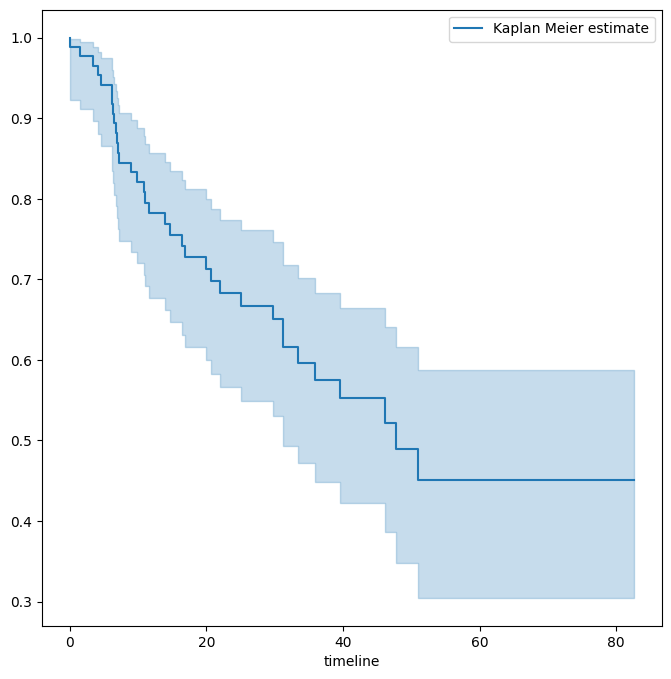

In [5]:
fig, ax = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot(label='Kaplan Meier estimate', ax=ax)

### The Log-Rank Test
Now we want to create Kaplan-Meier survival curves from the BrainCancer data that are separated by sex. We do this using the `groupby()` method of a dataframe. 

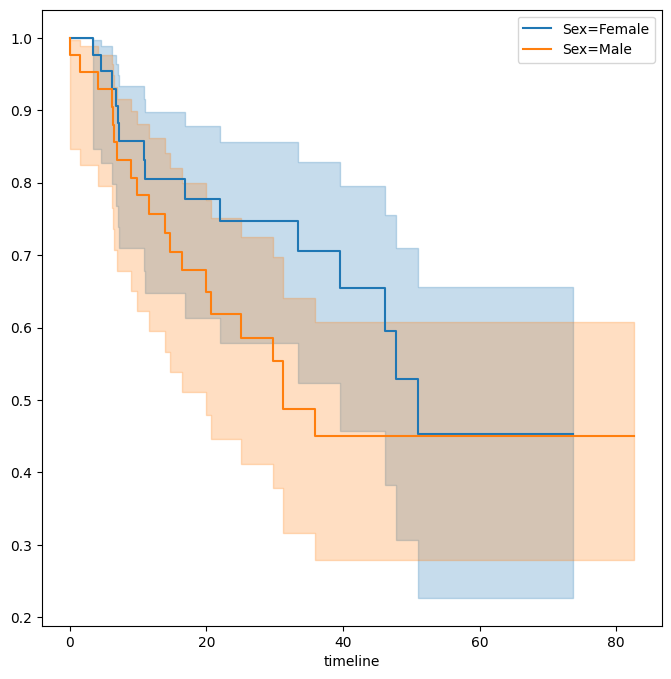

In [6]:
fig, ax = subplots(figsize=(8,8))
by_sex = {}
for sex, df in BrainCancer.groupby('sex'):
    by_sex[sex] = df
    km_sex = km.fit(df['time'], df['status'])
    km_sex.plot(label='Sex=%s' % sex, ax=ax)

We can use a log-rank test to compare the survival curves for males versus females. We use the `logrank_test()` function from the `lifelines.statistics module`. 

In [7]:
logrank_test(by_sex['Male']['time'],
             by_sex['Female']['time'],
             by_sex['Male']['status'],
             by_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

The resulting p-value is 0.23 which is greater than 0.05, so there is no evidence of a difference in the survival
between the two sexes.

### The Cox Proportional Hazards Model
We have seen the restults from the log-rank test that compares the survival curves for males versus females form the BrainCancer data. Now we can fit a Cox proportional hazards model to test the exact samme thing, using the `CoxPHFitter()`. To begin, we consider a model that uses sex as the only predictor.

In [8]:
coxph = CoxPHFitter # shorthand
sex_df = BrainCancer[['time', 'status', 'sex']]
model_df = MS(['time', 'status', 'sex'],
              intercept=False).fit_transform(sex_df)
cox_fit = coxph().fit(model_df,
                      'time',
                      'status')
cox_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.407668,0.342004,0.233262


The p-value for the hypothesis test $H_0: \beta = 0$ is 0.233 which is not significant so we conclude that there is no difference in the survival rates between males and females. This is the same conclusion we found for the log-rank test.

Now let's try to fit a model with multiple predictors. Note that the covariates included are either quanititative or qualitative with a binary response with the exception of `diagnosis`. The `diagnosis` variable has four classes: `Meningioma`, `LG glioma`, `HG glioma`, and `Other`. 

In [9]:
cleaned = BrainCancer.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph().fit(all_df,
                      'time',
                      'status')
fit_all.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.183748,0.360358,0.610119
diagnosis[LG glioma],-1.239530,0.579555,0.032455
diagnosis[Meningioma],-2.154566,0.450524,0.000002
diagnosis[Other],-1.268870,0.617672,0.039949
loc[Supratentorial],0.441195,0.703669,0.530665
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
stereo[SRT],0.177778,0.601578,0.767597


Since `Meningioma` was coded as the baseline, the fitted coefficient 2.15 associated with `HG glioma` means that the risk associated with `HG glioma` is $e^{2.15} = 8.62$ times more that the risk of `Meningioma`.

We can plot the survival curves for each diagnosis category while adusting for the other predictors. To make these plots we make a new data set where the value for each of the other predictors is the mean (if quantitative) or mode (if qualitative) of the variable. 

In [12]:
# Plot estimated survival curves for each diagnosis category
levels = cleaned['diagnosis'].unique()
def representative(series):
    if hasattr(series.dtype, 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()
modal_data = cleaned.apply(representative, axis=0)

modal_df = pd.DataFrame(
              [modal_data.iloc[0] for _ in range(len(levels))])
modal_df['diagnosis'] = levels
modal_df

modal_X = all_MS.transform(modal_df)
modal_X.index = levels
modal_X

# Use the predict_survival_function() method to obtain the estimated survival function.
predicted_survival = fit_all.predict_survival_function(modal_X)
predicted_survival

,Meningioma,HG glioma,LG glioma,Other
0.07,0.997947,0.982430,0.994881,0.995029
1.18,0.997947,0.982430,0.994881,0.995029
1.41,0.995679,0.963342,0.989245,0.989555
1.54,0.995679,0.963342,0.989245,0.989555
2.03,0.995679,0.963342,0.989245,0.989555
...,...,...,...,...
65.02,0.688772,0.040136,0.394181,0.404936
67.38,0.688772,0.040136,0.394181,0.404936
73.74,0.688772,0.040136,0.394181,0.404936
78.75,0.688772,0.040136,0.394181,0.404936


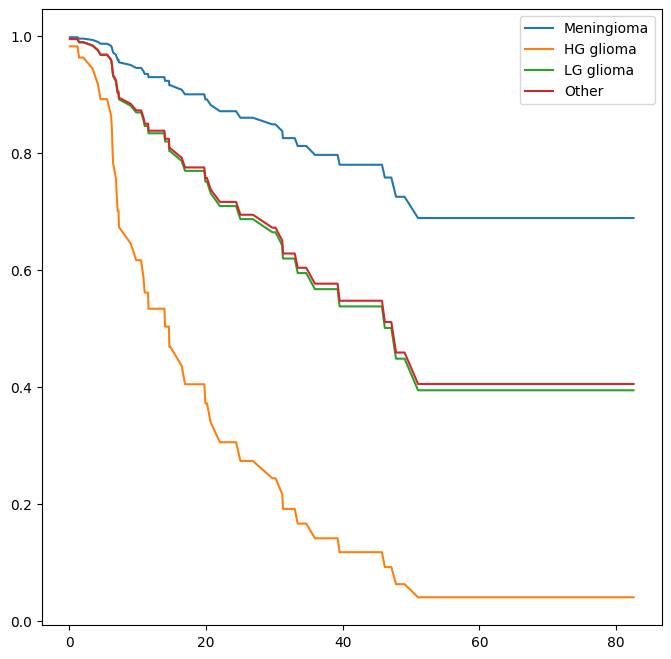

In [13]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax);

*These exercises were adapted from :* James, Gareth, et al. An Introduction to Statistical Learning: with Applications in Python, Springer, 2023.